<a href="https://colab.research.google.com/github/SpectraGbes/Spectragbes/blob/main/Candlestick_%26_Comparison_Builder_(2025).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Candlestick & Comparison Builder (2025)
import argparse
import os
from typing import Dict, List
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import Image, display

DEFAULT_TICKERS = ["MSFT","AAPL","AMZN","GOOG","NVDA","ORCL"]

FNAME_MAP = {
    "MSFT": "msft_us_d.csv",
    "AAPL": "aapl_us_d.csv",
    "AMZN": "amzn_us_d.csv",
    "GOOG": "goog_us_d.csv",
    "NVDA": "nvda_us_d.csv",
    "ORCL": "orcl_us_d.csv",
}

def tidy_load(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    req = {"date","open","high","low","close","volume"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"{os.path.basename(path)} missing columns: {missing}")
    df['date'] = pd.to_datetime(df['date'])
    for c in ["open","high","low","close","volume"]:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.sort_values('date')
    df25 = df[(df['date'] >= '2025-01-01') & (df['date'] <= '2025-12-31')].copy()
    if df25.empty:
        raise ValueError(f"No 2025 rows in {os.path.basename(path)}")
    df25['ma50'] = df25['close'].rolling(50).mean()
    df25['ma200'] = df25['close'].rolling(200).mean()
    df25['return'] = df25['close'].pct_change()
    return df25

def plot_candles(df: pd.DataFrame, ticker: str, out_dir: str) -> str:
    dates = mdates.date2num(np.array(df['date'].dt.to_pydatetime()))
    ohlc = list(zip(dates, df['open'], df['high'], df['low'], df['close']))
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_axes([0.06, 0.25, 0.93, 0.70])
    ax_vol = fig.add_axes([0.06, 0.08, 0.93, 0.13], sharex=ax)

    for d,o,h,l,c in ohlc:
        color = '#2ca02c' if c >= o else '#d62728'
        ax.vlines(d, l, h, color=color, linewidth=1)
        body_width = 0.7
        ax.add_patch(plt.Rectangle((d - body_width/2, min(o,c)), body_width, abs(c-o),
                                   facecolor=color, edgecolor=color, linewidth=0.5))
    ax.plot(df['date'], df['ma50'], color='#1f77b4', linewidth=1.8, label='MA 50')
    ax.plot(df['date'], df['ma200'], color='#ff7f0e', linewidth=1.8, label='MA 200')

    yr_high = float(df['high'].max()); yr_low = float(df['low'].min())
    d_high = df.loc[df['high'].idxmax(), 'date']
    d_low = df.loc[df['low'].idxmin(), 'date']
    ax.scatter([d_high, d_low], [yr_high, yr_low], color='black', zorder=3, s=50)
    ax.annotate(f'2025 High: {yr_high:,.2f}\n({d_high.date()})', xy=(d_high, yr_high),
                xytext=(30,25), textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', fc='lightgreen', alpha=0.7))
    ax.annotate(f'2025 Low: {yr_low:,.2f}\n({d_low.date()})', xy=(d_low, yr_low),
                xytext=(-60,-40), textcoords='offset points', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', fc='salmon', alpha=0.7))

    ax.set_title(f'{ticker} - Daily Candlesticks (2025)', fontsize=16)
    ax.set_ylabel('Price (USD)', fontsize=12)
    ax.legend(loc='upper left', frameon=True, fontsize=10)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    ax.grid(True, linestyle='--', alpha=0.5)

    ax_vol.bar(df['date'], df['volume'], width=0.8, color='#7f7f7f')
    ax_vol.set_ylabel('Volume', fontsize=12)
    ax_vol.grid(True, linestyle='--', alpha=0.5)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    out_png = os.path.join(out_dir, f'{ticker}_2025_candlesticks.png')
    fig.savefig(out_png, dpi=240)
    plt.close(fig)
    return out_png

def metrics(df: pd.DataFrame):
    start = df['close'].iloc[0]; end = df['close'].iloc[-1]
    ytd = (end/start) - 1.0
    vol = df['return'].std() * math.sqrt(252)
    return ytd, vol

def build_comparison(all_data: Dict[str, pd.DataFrame], out_dir: str) -> str:
    import pandas as pd
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(16,10))
    gs = fig.add_gridspec(3,3)
    ax1 = fig.add_subplot(gs[0:2,:])
    labels = list(all_data.keys())

    for t in labels:
        df = all_data[t]
        base = df['close'].iloc[0]
        ax1.plot(df['date'], df['close']/base*100.0, label=t)
    ax1.set_title('Normalized Price (Start=100) - 2025')
    ax1.set_ylabel('Index (Start=100)')
    ax1.legend(loc='upper left', ncol=3)

    ax2 = fig.add_subplot(gs[2,0])
    ytd_vals = []
    for t in labels:
        ytd, vol = metrics(all_data[t])
        ytd_vals.append(ytd*100)
    ax2.bar(labels, ytd_vals, color='#2ca02c')
    ax2.set_title('YTD Return (%)')

    ax3 = fig.add_subplot(gs[2,1])
    vols = []
    for t in labels:
        ytd, vol = metrics(all_data[t])
        vols.append(vol*100)
    ax3.bar(labels, vols, color='#1f77b4')
    ax3.set_title('Annualized Volatility (%)')

    ax4 = fig.add_subplot(gs[2,2])
    ret_df = pd.DataFrame({t: all_data[t]['return'] for t in labels}).dropna()
    corr = ret_df.corr()
    im = ax4.imshow(corr, cmap='RdBu', vmin=-1, vmax=1)
    ax4.set_xticks(range(len(labels)))
    ax4.set_yticks(range(len(labels)))
    ax4.set_xticklabels(labels, rotation=45, ha='right')
    ax4.set_yticklabels(labels)
    ax4.set_title('Daily Return Correlation')
    fig.colorbar(im, ax=ax4, fraction=0.046, pad=0.04)

    fig.tight_layout()
    out_png = os.path.join(out_dir, 'peers_comparison_2025_' + '_'.join(labels) + '.png')
    fig.savefig(out_png, dpi=240)
    plt.close(fig)
    return out_png

def run(data_dir: str, out_dir: str, tickers: List[str]):
    os.makedirs(out_dir, exist_ok=True)
    all_data = {}
    for t in tickers:
        fname = FNAME_MAP.get(t, t.lower() + '_us_d.csv')
        path = os.path.join(data_dir, fname)
        if not os.path.exists(path):
            print(f'[skip] {t}: file not found at {path}')
            continue
        try:
            df25 = tidy_load(path)
            all_data[t] = df25
            png = plot_candles(df25, t, out_dir)
            print(f'[ok] {t}: saved {png}')
        except Exception as e:
            print(f'[fail] {t}: {e}')
    if len(all_data) >= 2:
        comp = build_comparison(all_data, out_dir)
        print(f'[ok] comparison: saved {comp}')
    else:
        print('[warn] Not enough tickers for comparison (need >= 2)')

def parse_args(args=None):
    p = argparse.ArgumentParser(description='Build 2025 candlesticks and comparison for given tickers.')
    p.add_argument('--data-dir', type=str, default='.', help='Directory containing CSV files')
    p.add_argument('--out-dir', type=str, default='../output', help='Directory to save PNG outputs')
    p.add_argument('--tickers', type=str, default=','.join(DEFAULT_TICKERS), help='Comma-separated tickers')
    return p.parse_args(args)

if __name__ == '__main__':
    args = parse_args([])
    tickers = [t.strip().upper() for t in args.tickers.split(',') if t.strip()]
    run(args.data_dir, args.out_dir, tickers)


[skip] MSFT: file not found at ./msft_us_d.csv


/tmp/ipython-input-3987571336.py:43: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  dates = mdates.date2num(np.array(df['date'].dt.to_pydatetime()))
/tmp/ipython-input-3987571336.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


[ok] AAPL: saved ../output/AAPL_2025_candlesticks.png


/tmp/ipython-input-3987571336.py:43: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  dates = mdates.date2num(np.array(df['date'].dt.to_pydatetime()))
/tmp/ipython-input-3987571336.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


[ok] AMZN: saved ../output/AMZN_2025_candlesticks.png


/tmp/ipython-input-3987571336.py:43: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  dates = mdates.date2num(np.array(df['date'].dt.to_pydatetime()))
/tmp/ipython-input-3987571336.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


[ok] GOOG: saved ../output/GOOG_2025_candlesticks.png


/tmp/ipython-input-3987571336.py:43: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  dates = mdates.date2num(np.array(df['date'].dt.to_pydatetime()))
/tmp/ipython-input-3987571336.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


[ok] NVDA: saved ../output/NVDA_2025_candlesticks.png


/tmp/ipython-input-3987571336.py:43: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  dates = mdates.date2num(np.array(df['date'].dt.to_pydatetime()))
/tmp/ipython-input-3987571336.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


[ok] ORCL: saved ../output/ORCL_2025_candlesticks.png
[ok] comparison: saved ../output/peers_comparison_2025_AAPL_AMZN_GOOG_NVDA_ORCL.png


### Candlestick Plots

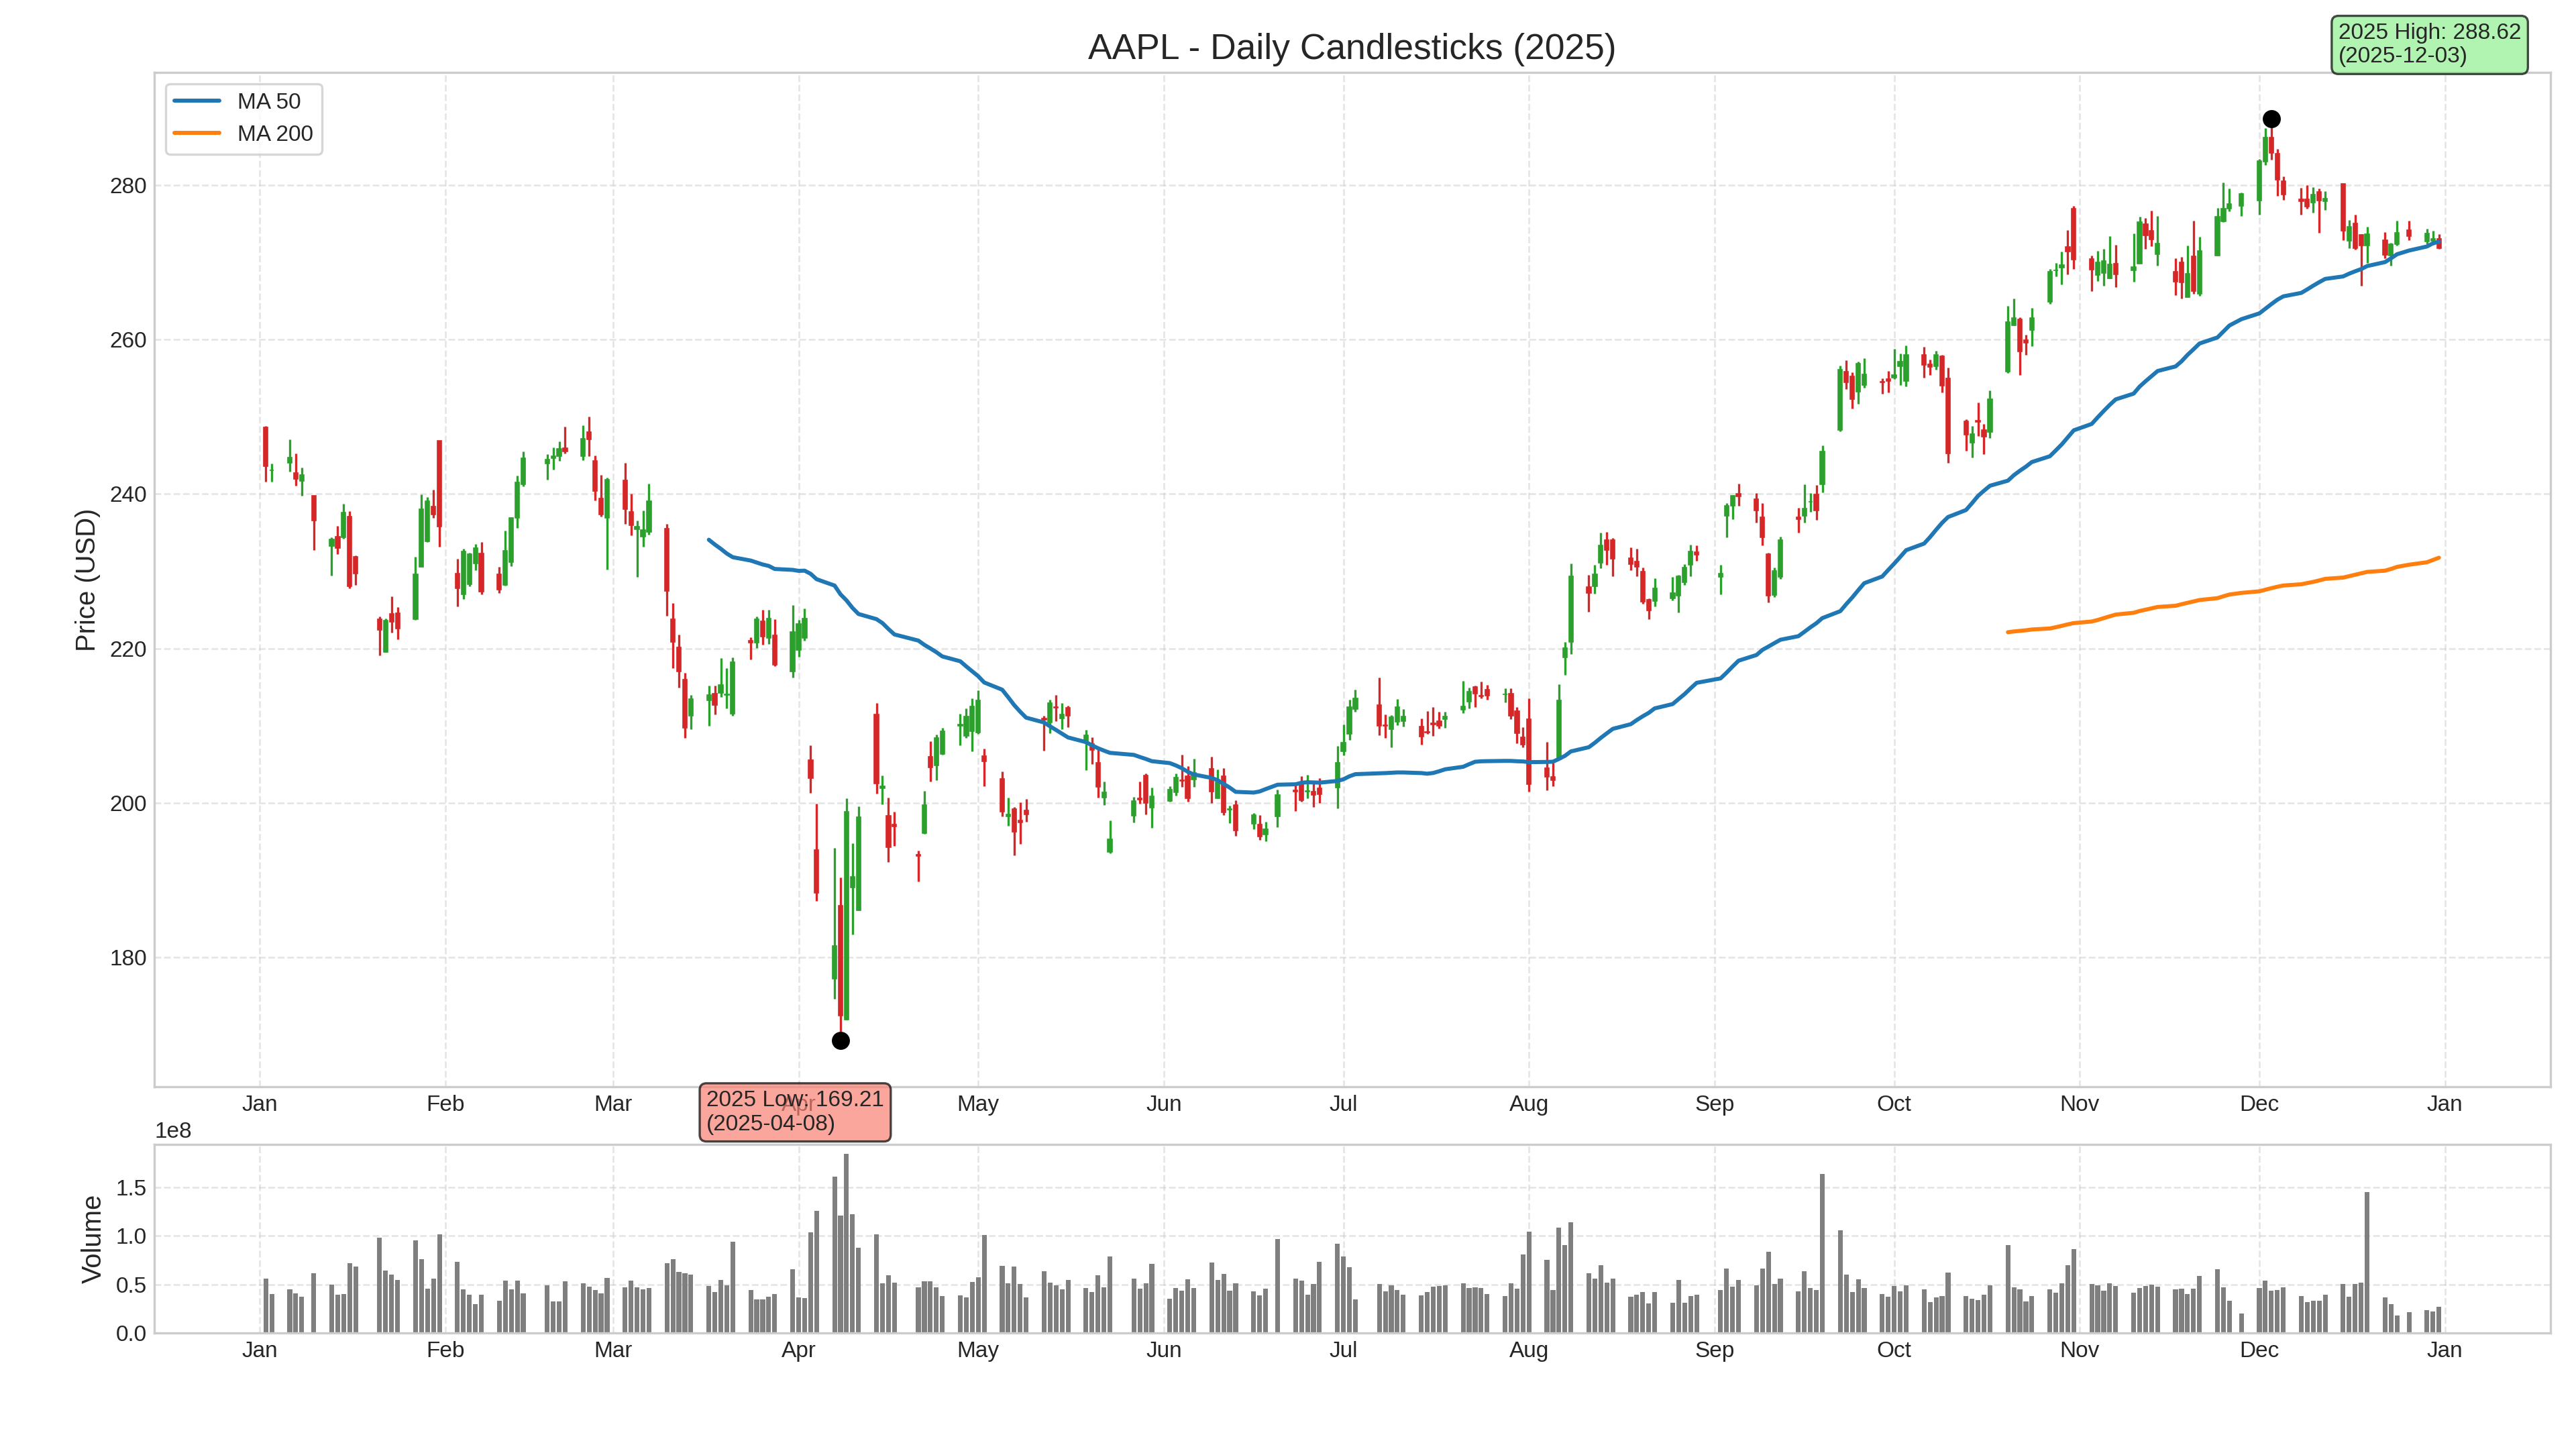

In [6]:
display(Image(filename='../output/AAPL_2025_candlesticks.png'))


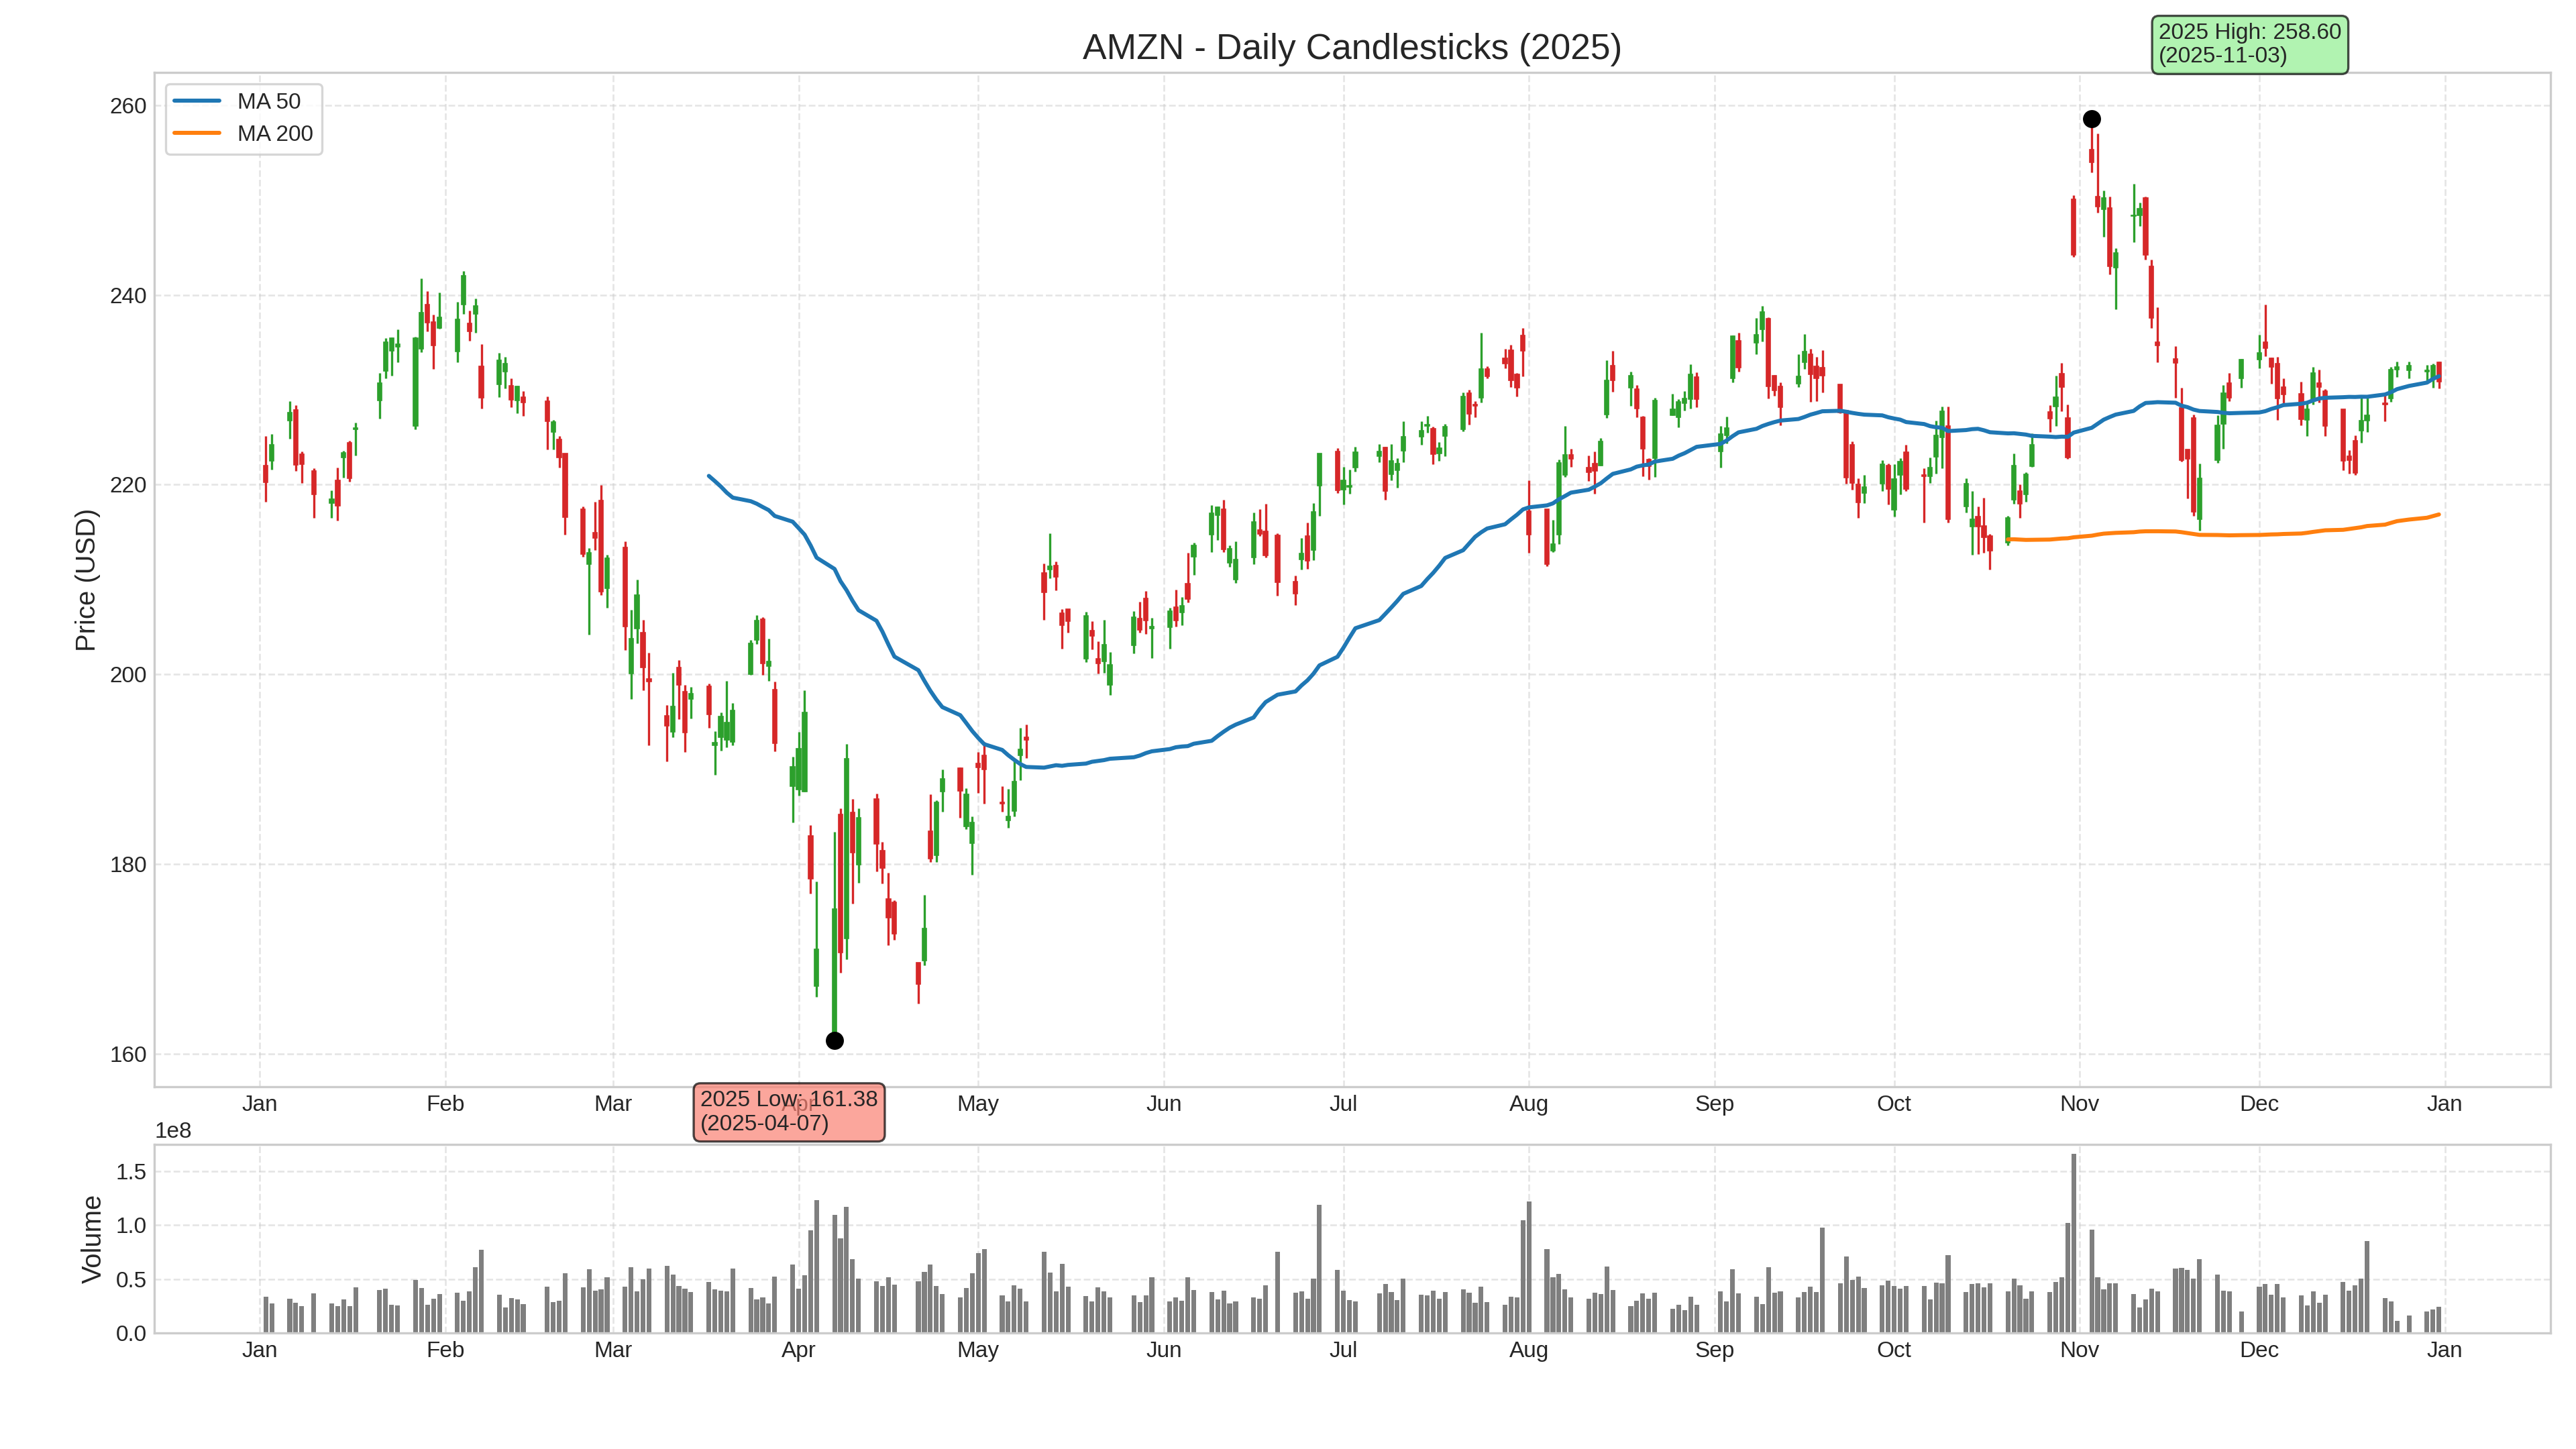

In [7]:
display(Image(filename='../output/AMZN_2025_candlesticks.png'))


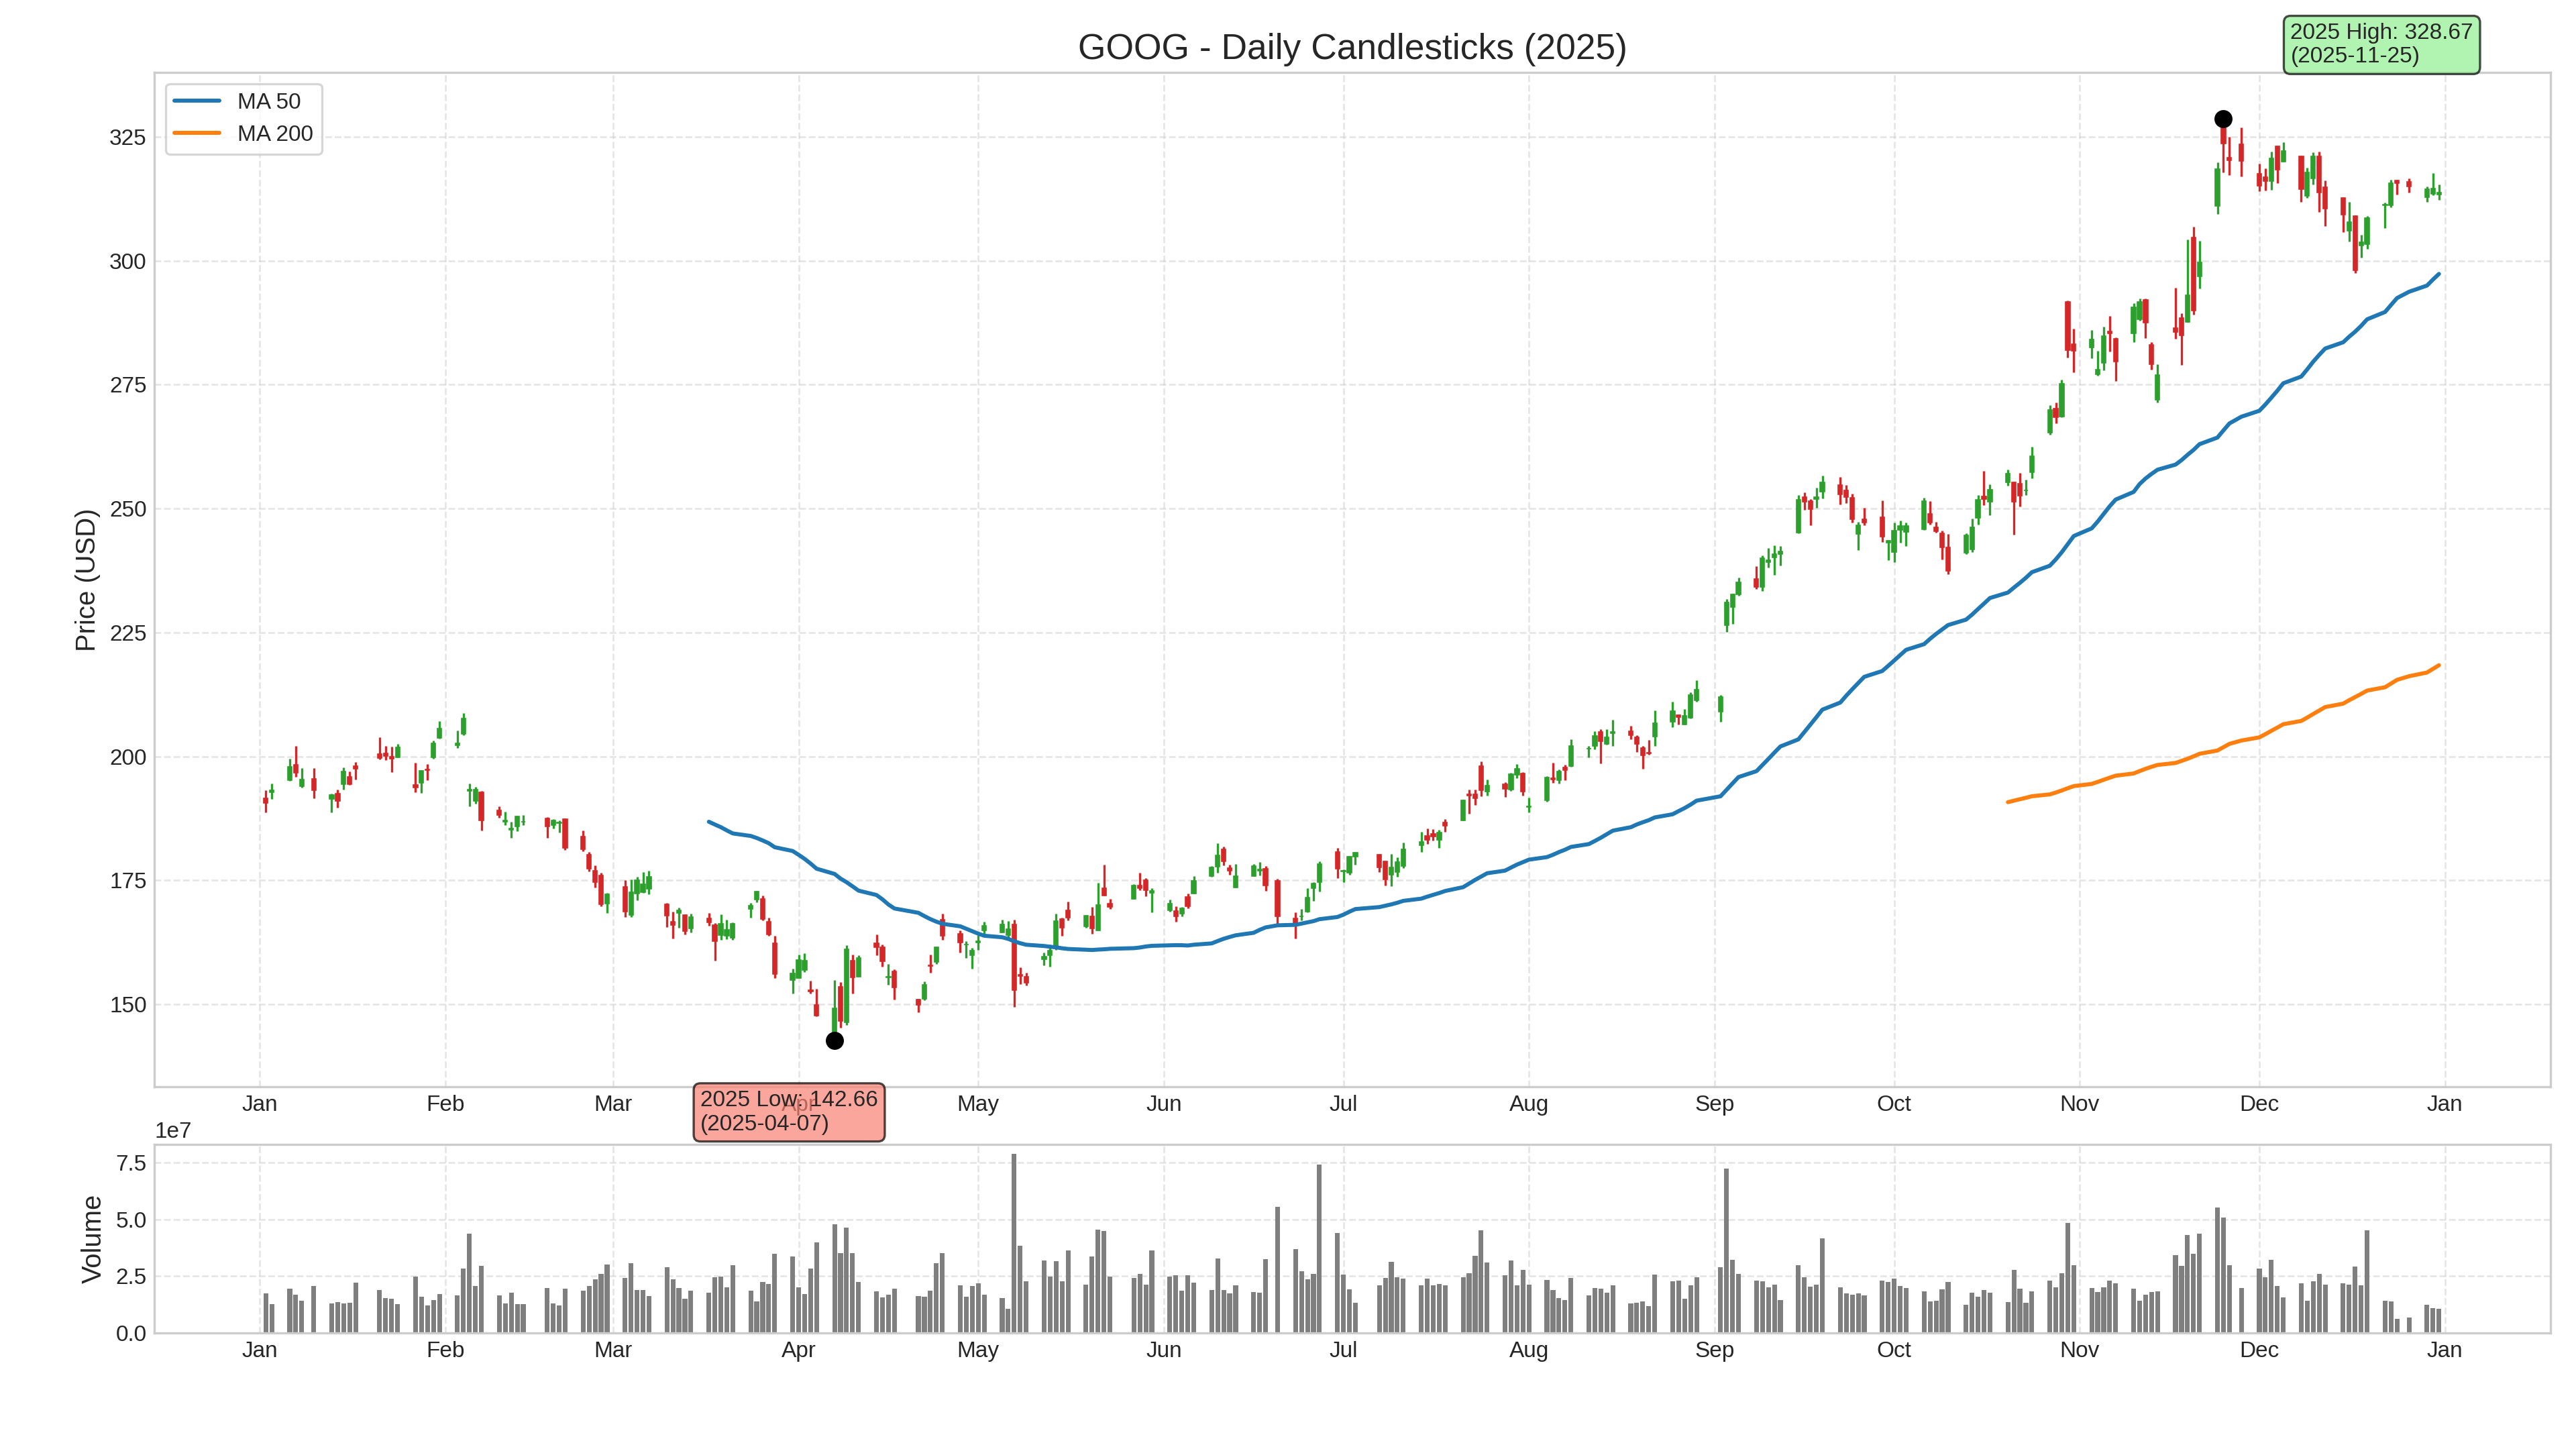

In [8]:
display(Image(filename='../output/GOOG_2025_candlesticks.png'))


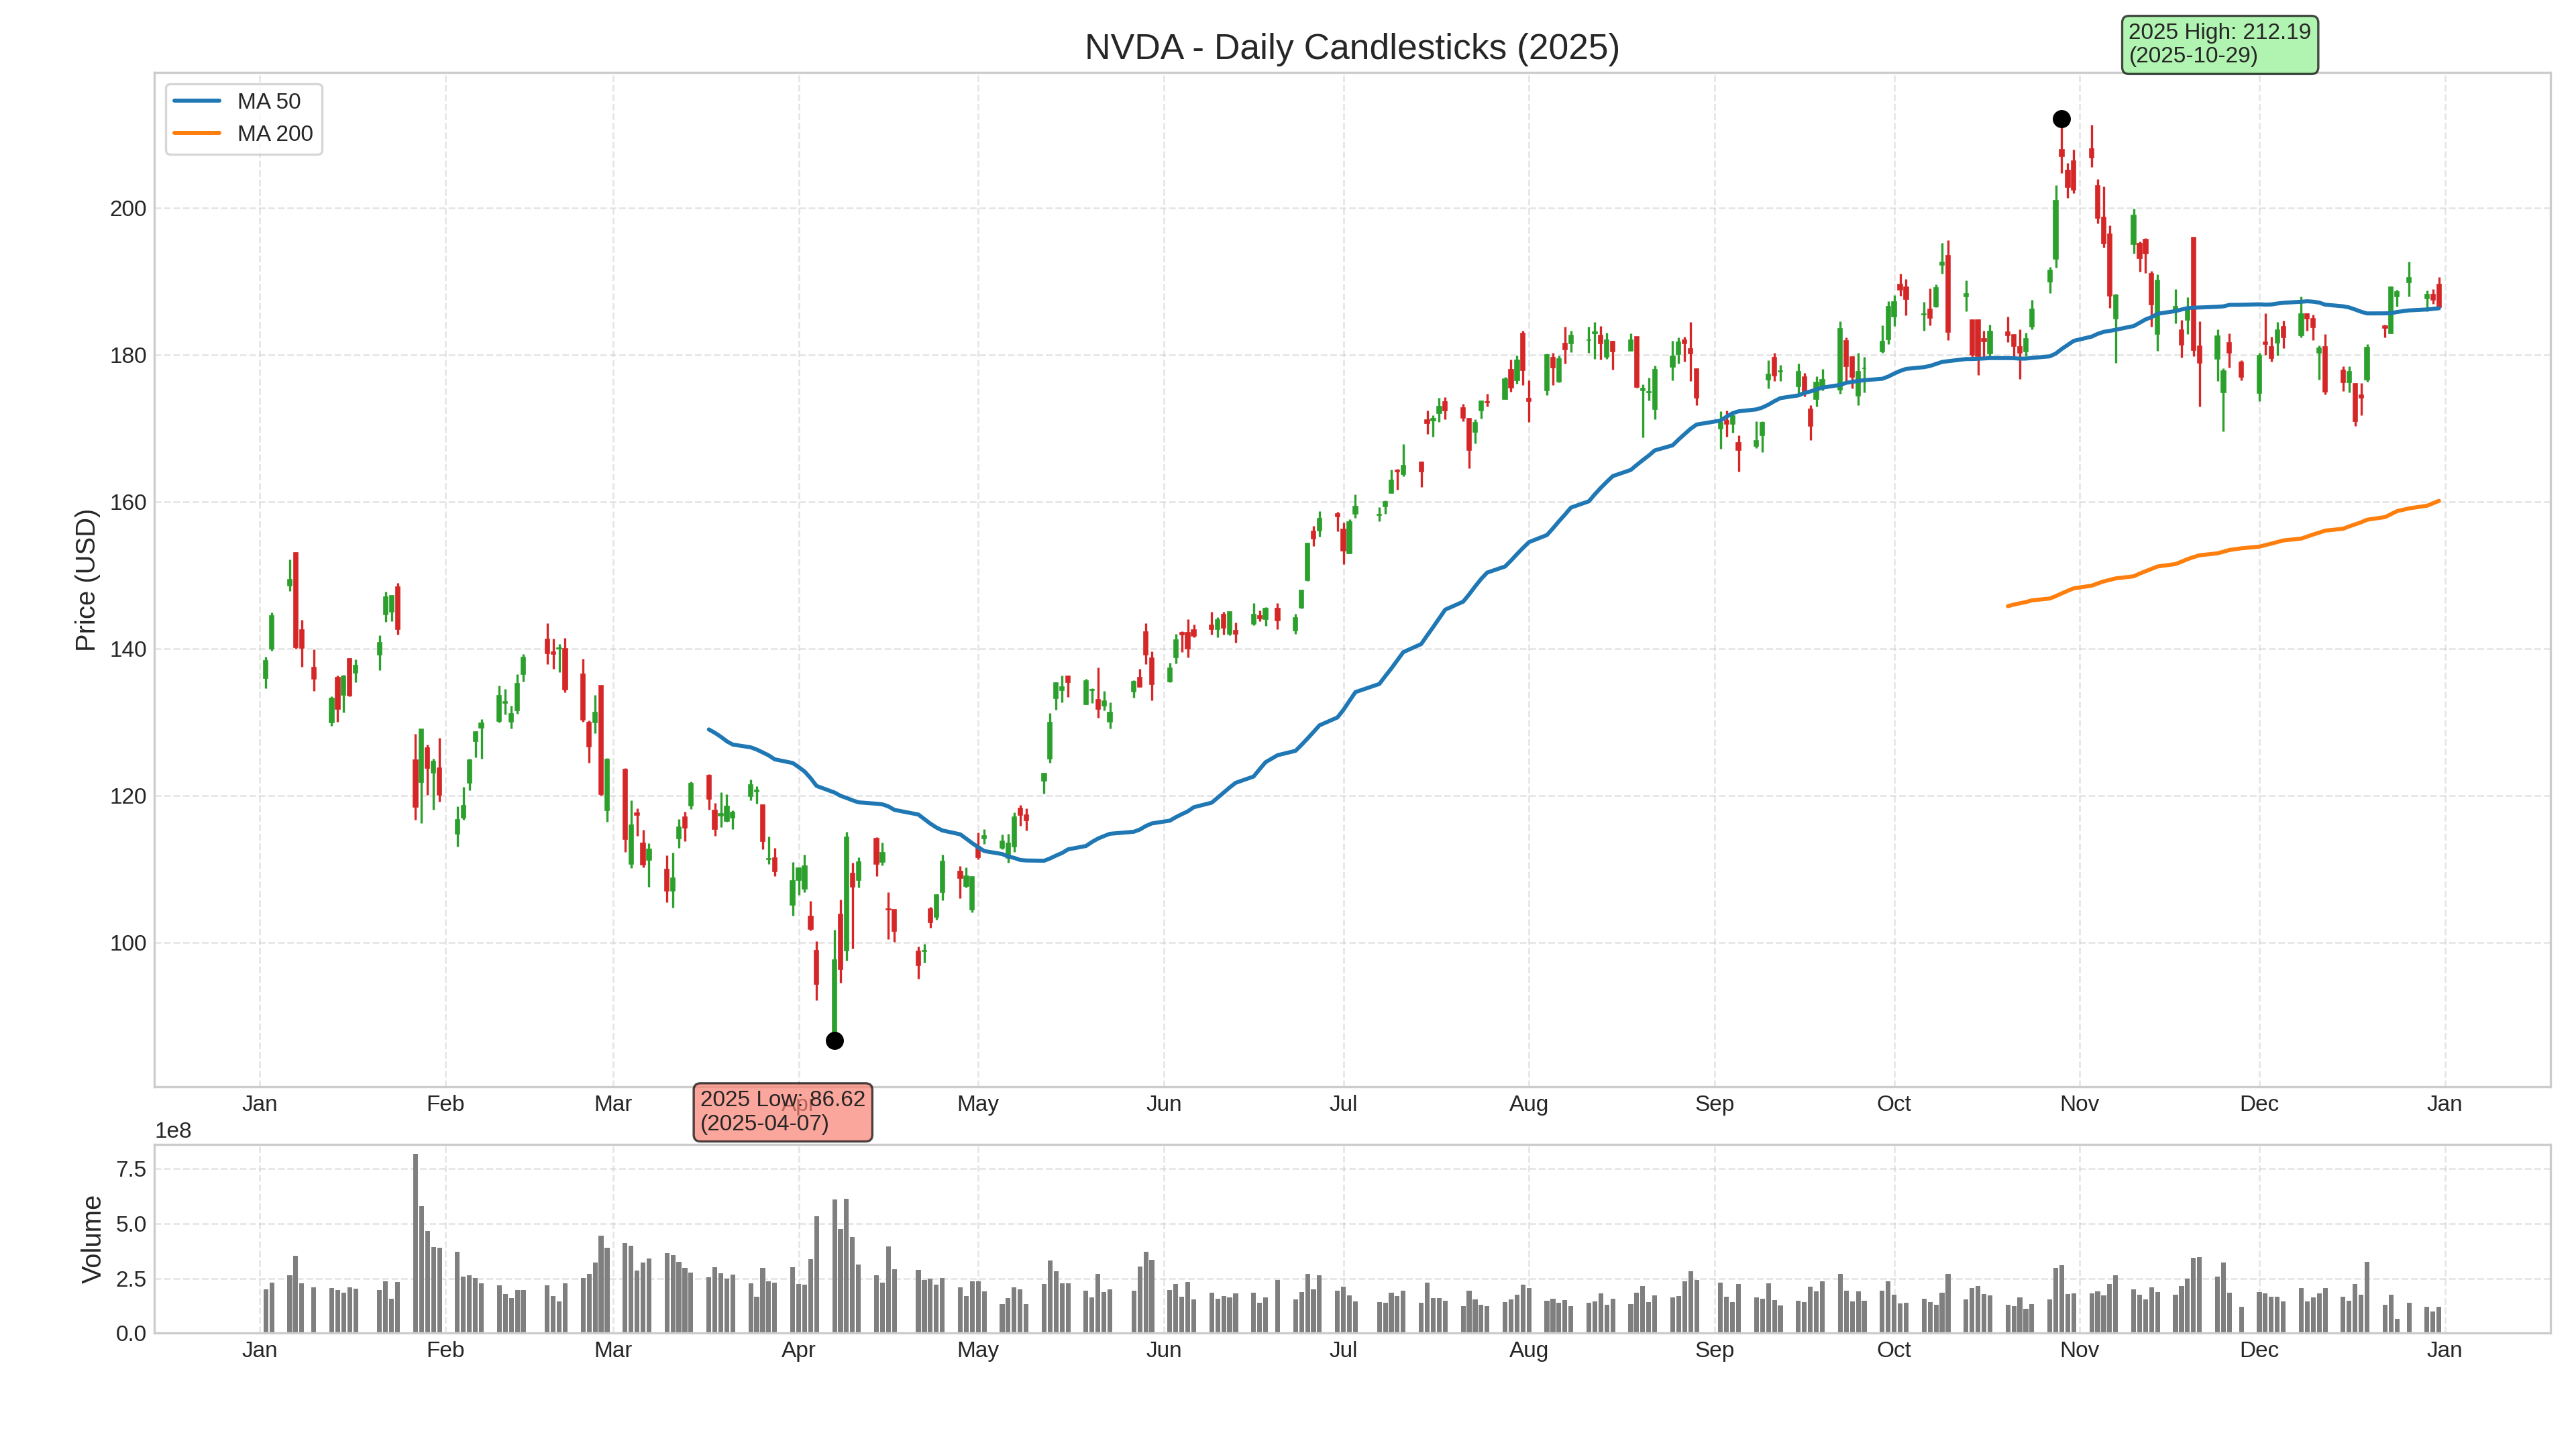

In [9]:
display(Image(filename='../output/NVDA_2025_candlesticks.png'))


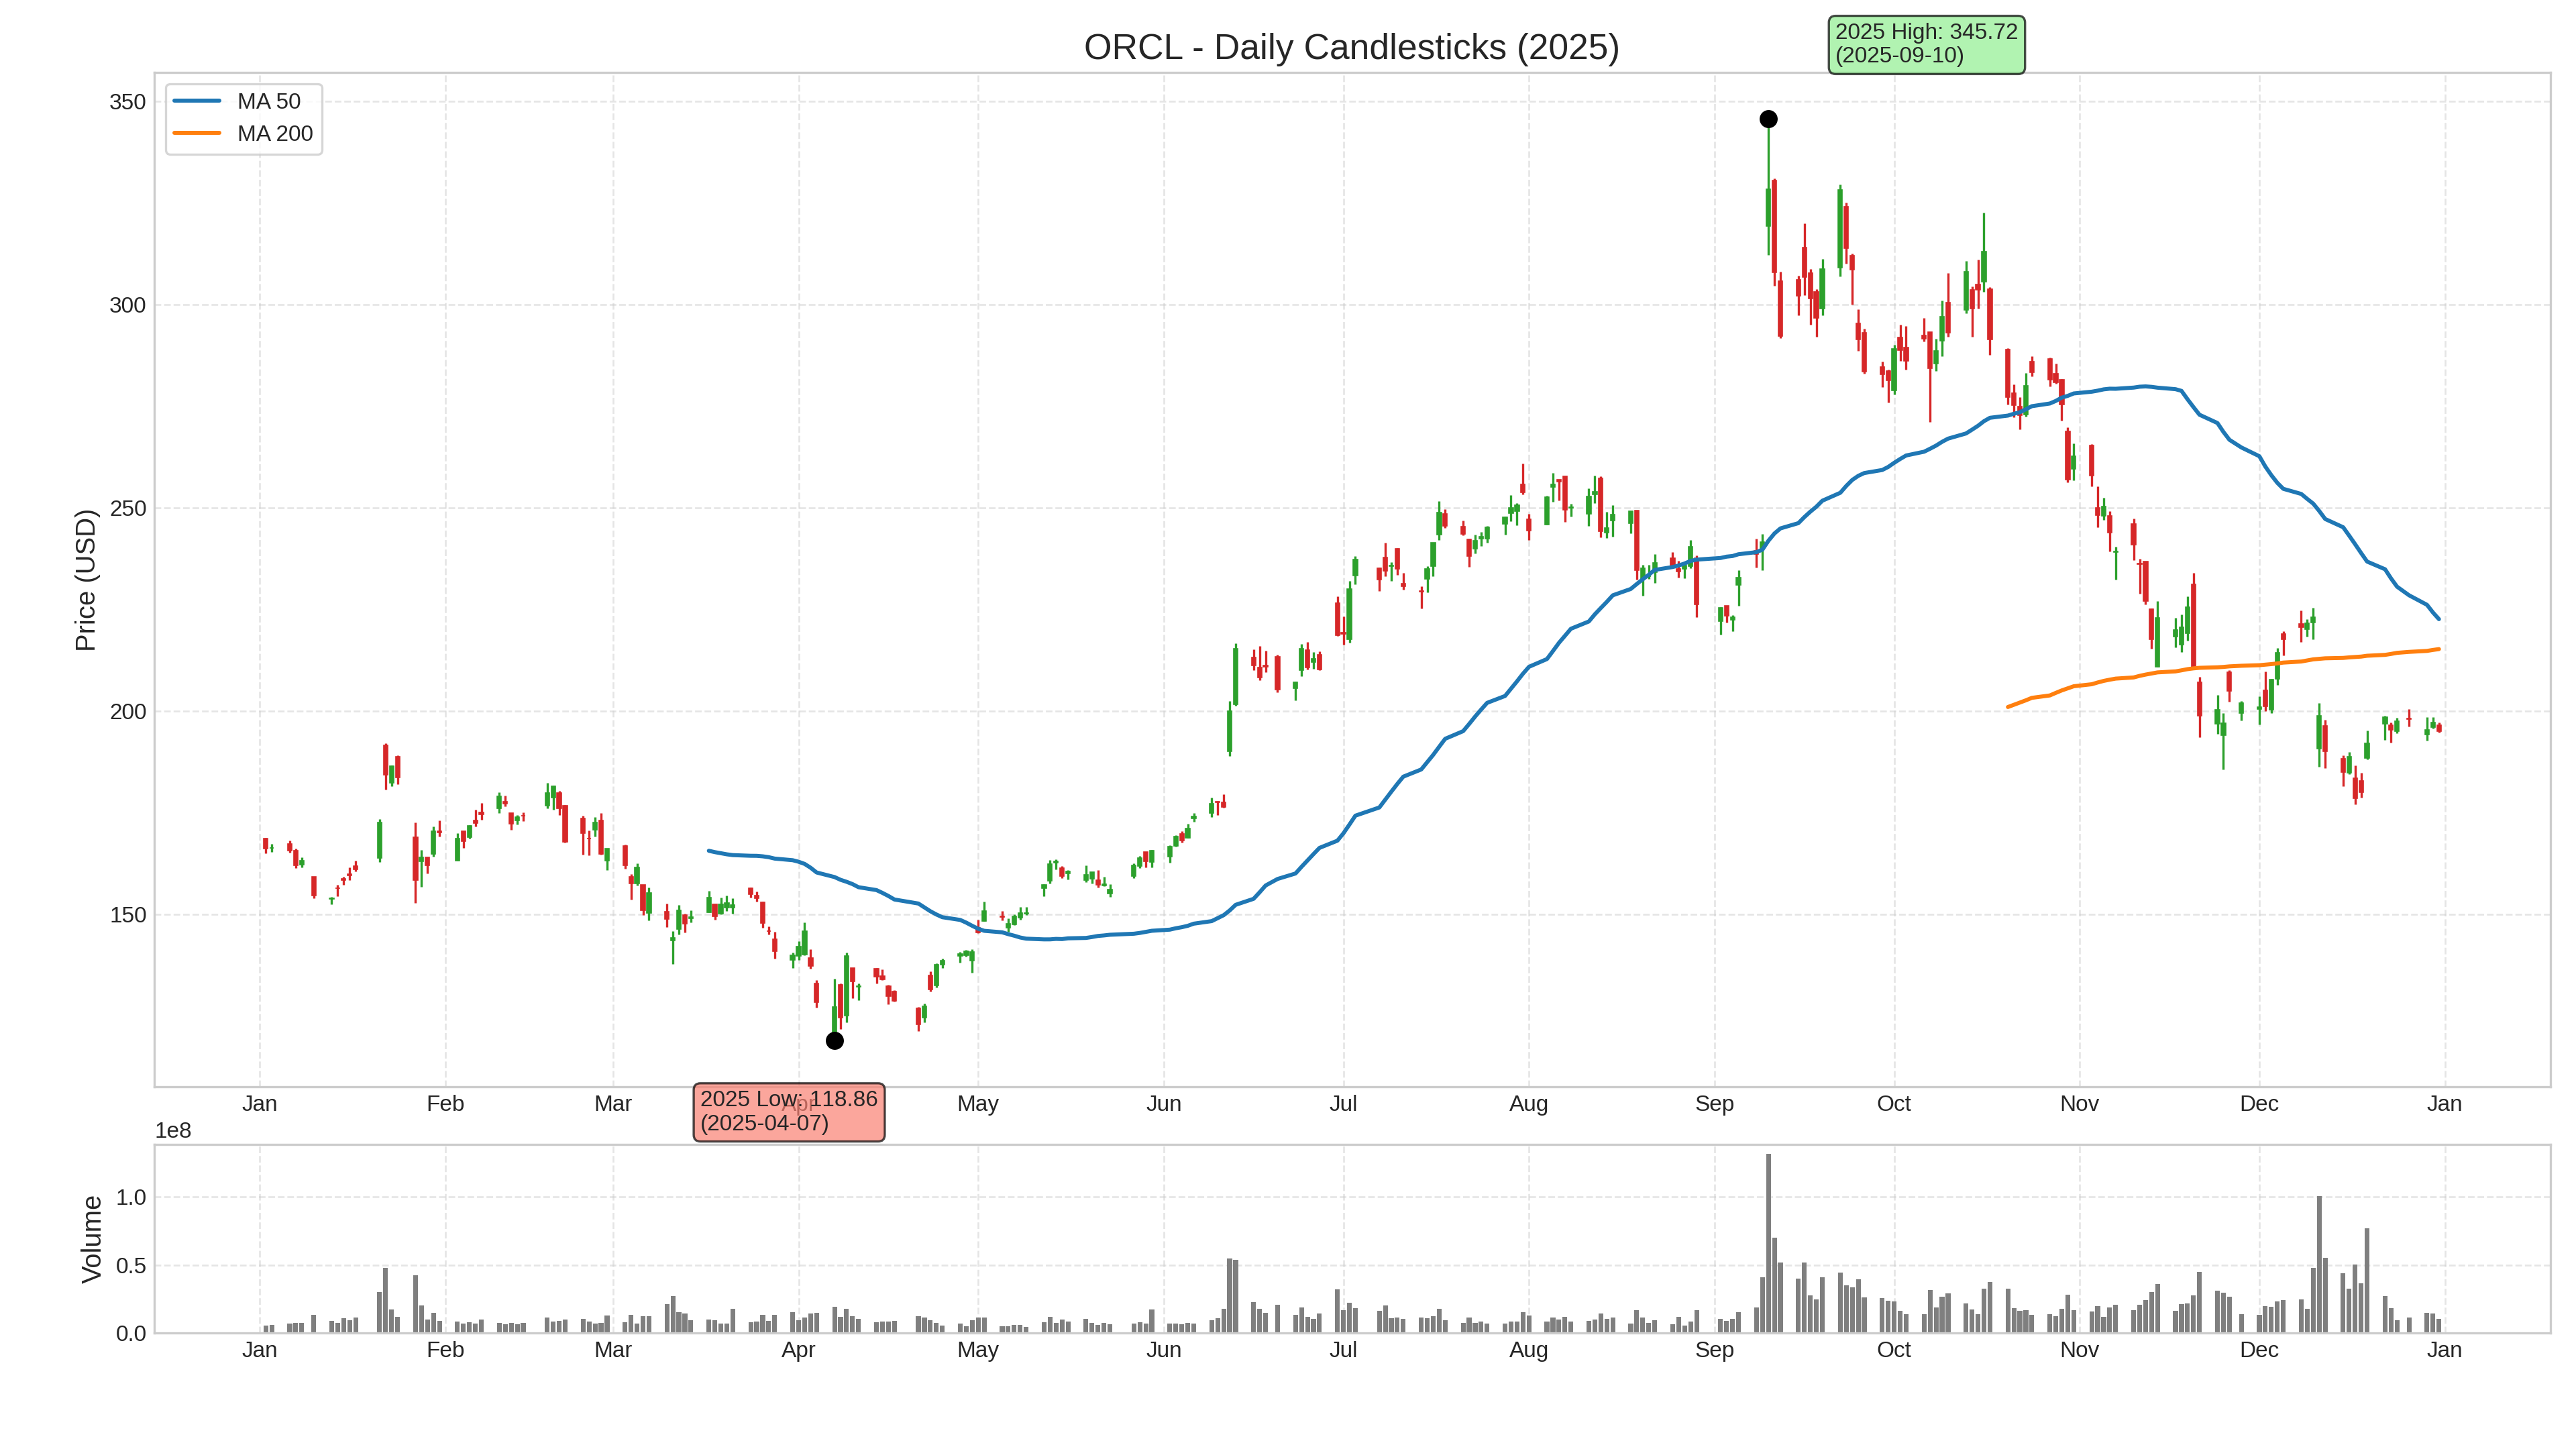

In [10]:
display(Image(filename='../output/ORCL_2025_candlesticks.png'))


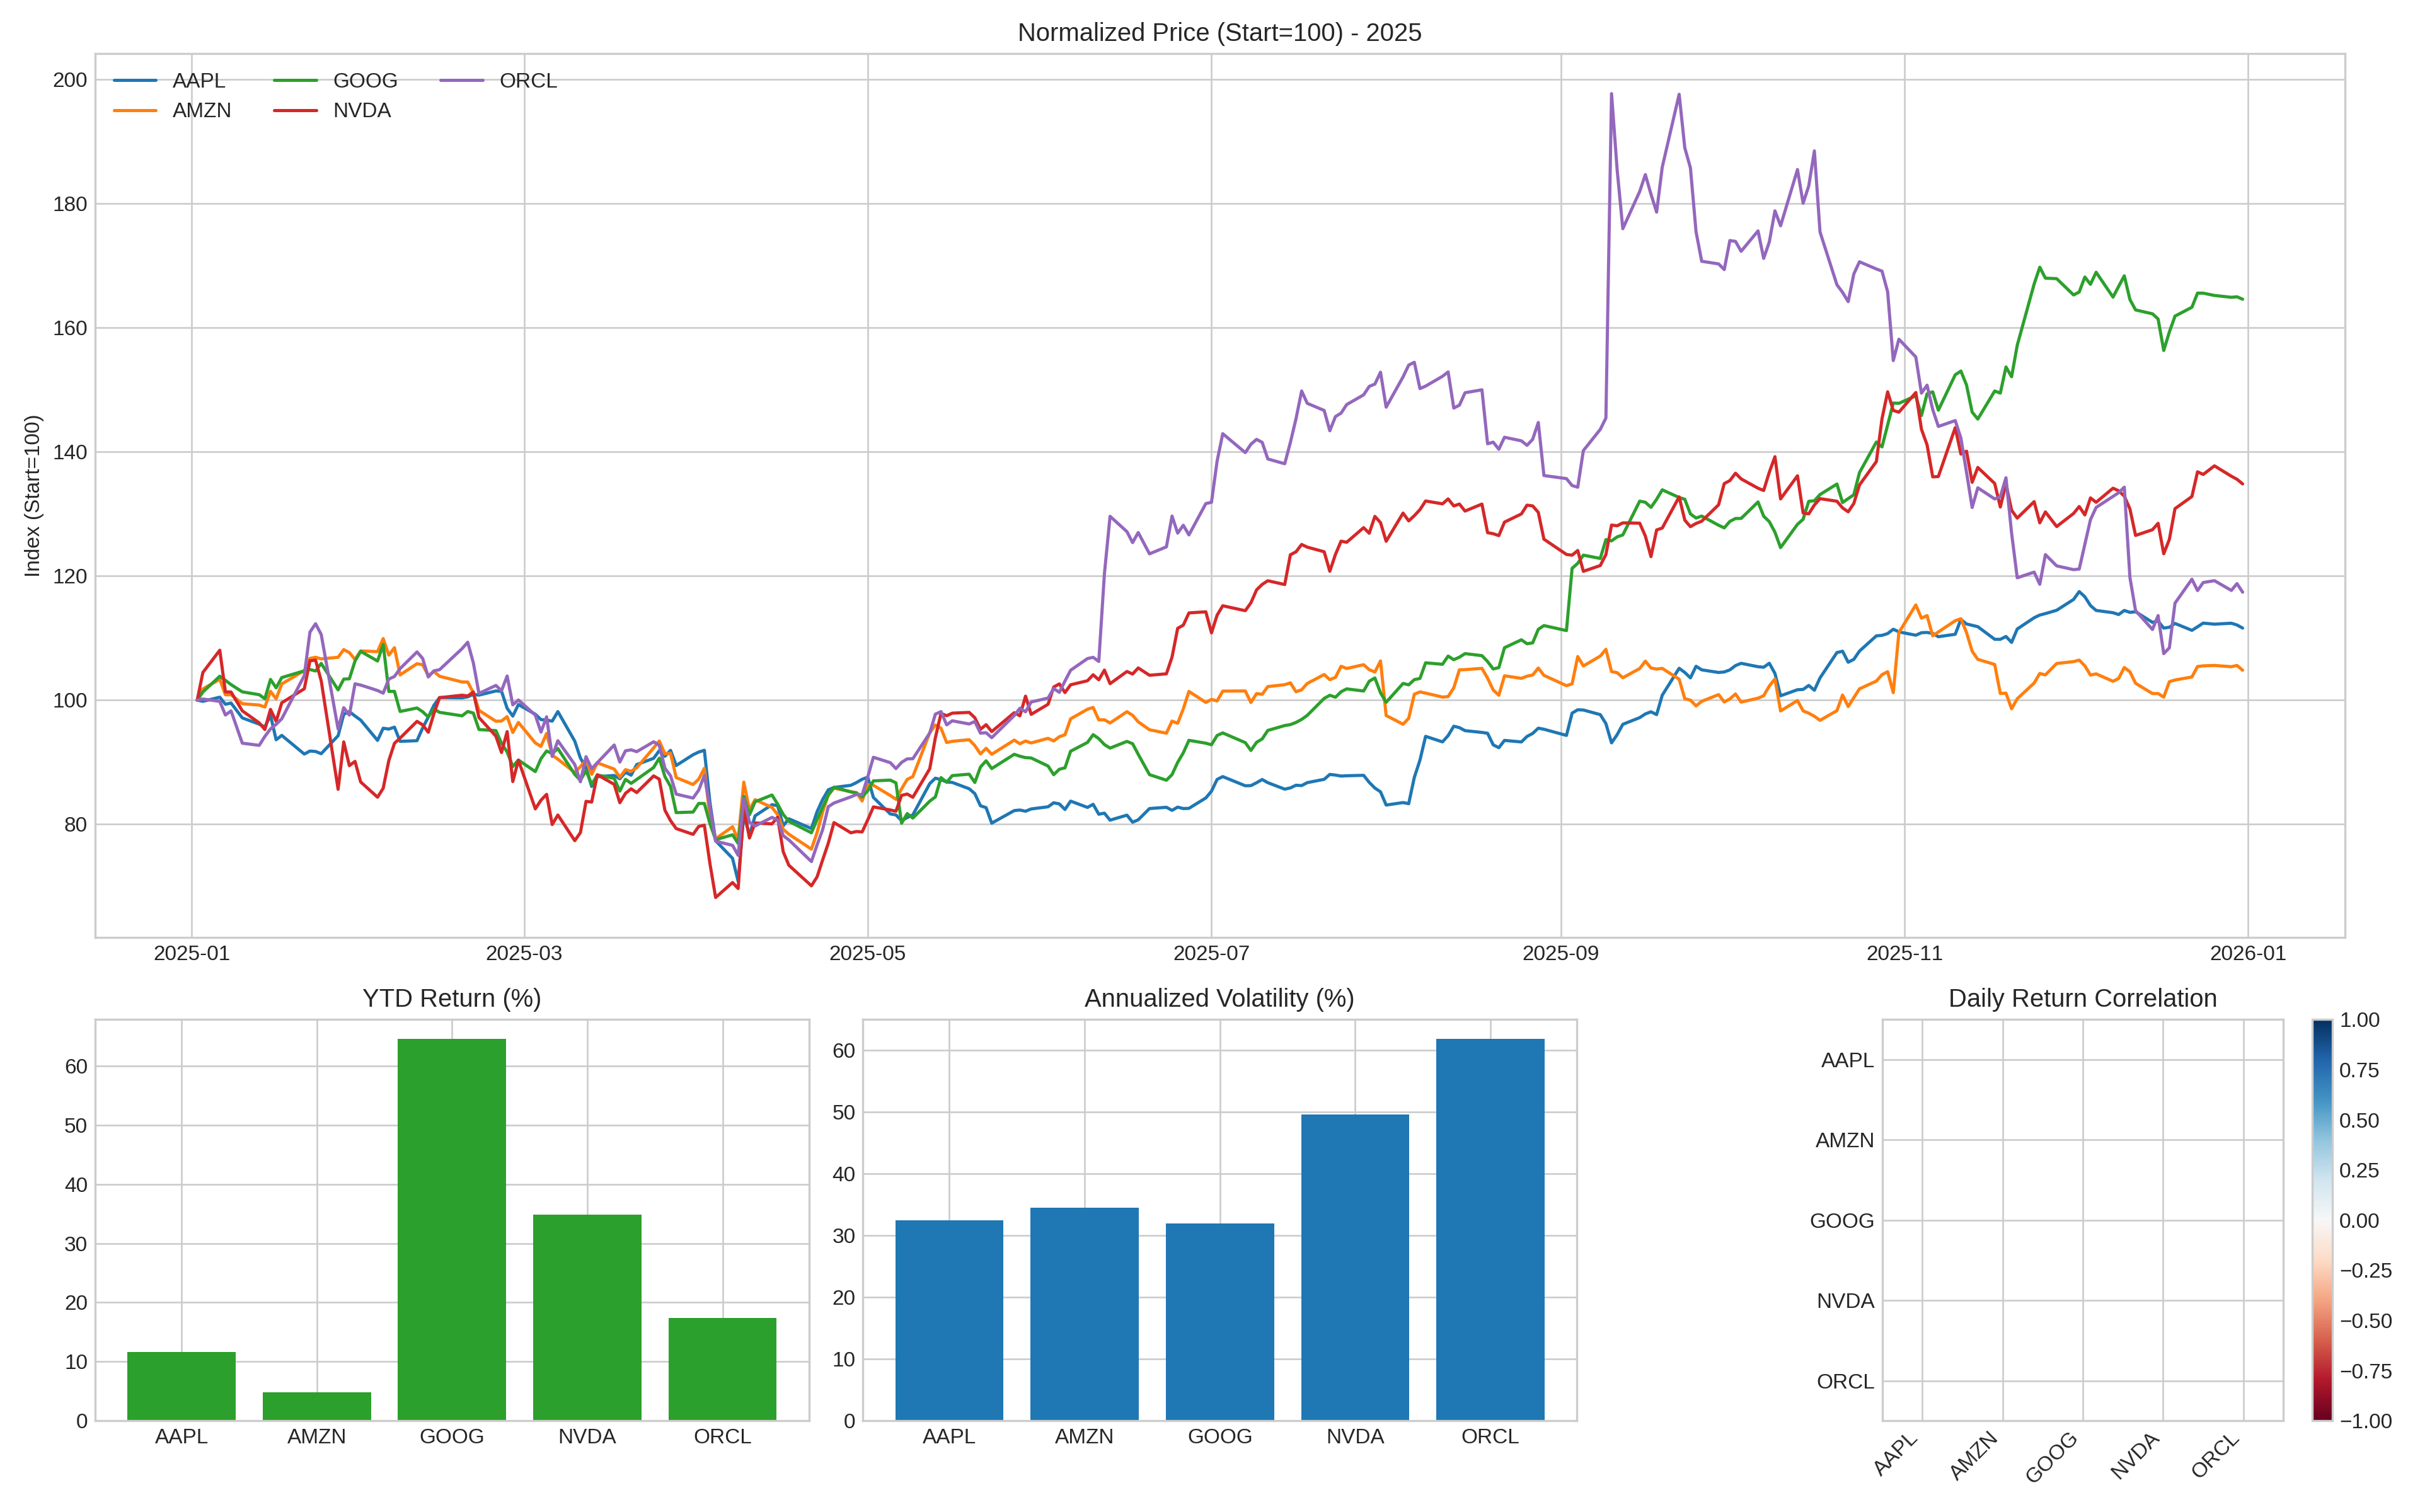

In [12]:
display(Image(filename='../output/peers_comparison_2025_AAPL_AMZN_GOOG_NVDA_ORCL.png'))